<center><h1> Non-Linear Transformation

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
%run ../TP2/logisticReg.py

In [2]:
df = pd.read_csv("data/data_QA.txt",header=None)
x=np.array(df.iloc[:,0:2])
y=np.array(df.iloc[:,2])
df.head()


,0,1,2
0,0.051267,0.69956,1
1,-0.092742,0.68494,1
2,-0.213710,0.69225,1
3,-0.375000,0.50219,1
4,-0.513250,0.46564,1


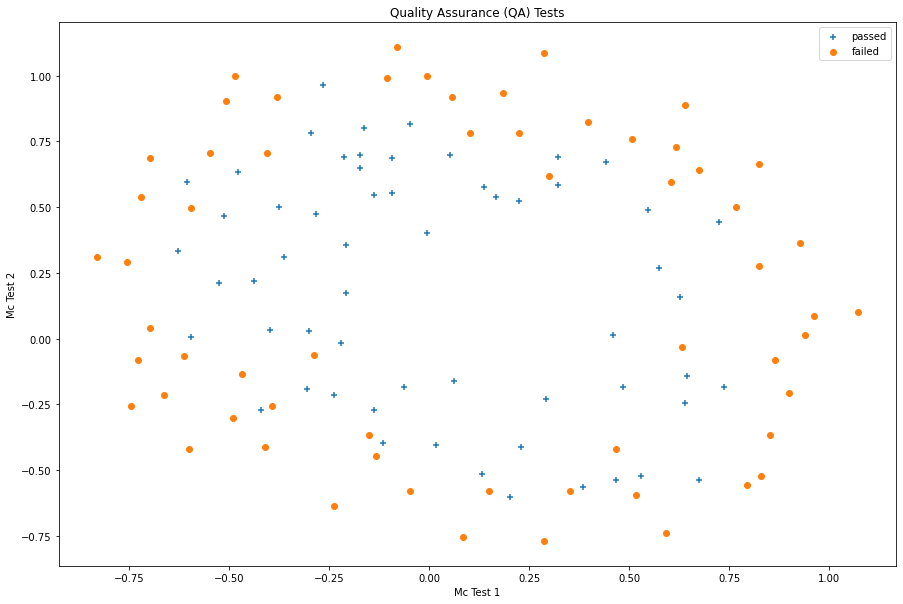

In [3]:
fig = plt.figure(figsize=(15,10))
mask = y==1
# plt.scatter(x[:,0],x[:,1],c=y,cmap='bwr',s=40,marker='o',label=y)
passed=plt.scatter(x[mask][:,0],x[mask][:,1],marker='+')
failed=plt.scatter(x[~mask][:,0],x[~mask][:,1])
plt.title("Quality Assurance (QA) Tests")
plt.xlabel("Mc Test 1")
plt.ylabel("Mc Test 2")
plt.legend((passed,failed),('passed','failed'))
plt.show()

#### What do you notice from the graph?
\
$\rightarrow$ It is impossible the fit a line to classify the data, all the microchips that passed the test are located in the center. So we need a circle to seperate the passed tests from the failed ones 

#### Apply the Logistic Regression to the data

In [4]:
X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.25, random_state=1234)
# Y_train = Y_train.reshape(-1,)
regressor = LogisticRegression(lr=1e-8,n_iter=1000)
regressor.fit(X_train,Y_train)

In [5]:
def accuracy (y_true, y_pred):
    return np.sum(y_true == y_pred)/ len(y_true)

In [6]:
## Reshape the weight matix
regressor.weights = regressor.weights.reshape(-1,1)

In [7]:
prediction = regressor.predict(X_test)
print(f"The accuracy of the Logitic regression model is : {accuracy(Y_test,prediction)}")

The accuracy of the Logitic regression model is : 0.6


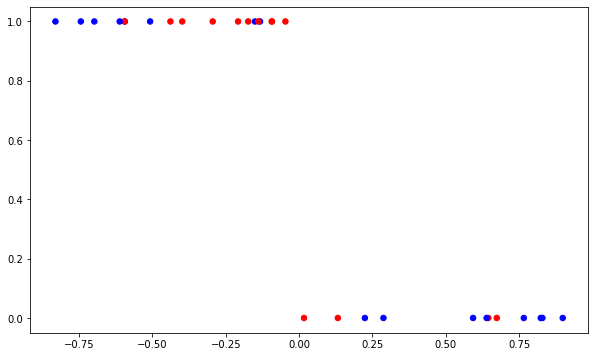

In [8]:
fig = plt.figure(figsize=(10,6))
plt.scatter(X_test[:,0],prediction,c=Y_test,cmap='bwr', marker="o",s=30)
plt.show()

As seen above, the accuracy of the logistic regression model for this kind of data is too low (accuracy = 60%), so the logistic regression isn't the best model for this type of data, we need a nonlinear classifier to do the job.

<h3> Sigmoid Activation Function
<h3>$h_w(x) = \frac{1}{1+e^{-w^T x}}$

In [28]:
def sigmoid(w,x):
    # w = w.reshape(len(w),-1)
    # x = x.reshape(-1,len(x))
    z = np.dot(x,w)
    return 1/(1 + np.exp(-z))

<h3>Cross-Entropy function
<h3>$$L_S(h_w) = \frac{1}{m} \sum_{i=1}^{m}{[y^{(i)} \log(h_{w}(x^{(i)})) + (1 - y^{(i)}) \log(1 - h_{w}(x^{(i)}))]} $$

In [29]:
def cross_entropy(y, h_w):
    m = len(y)
    return np.mean(y*(np.log(h_w)) - (1-y)*np.log(1-h_w))

In [32]:
print(f"shape of x : {Y_test.shape}")

shape of x : (30,)


In [34]:
print(f"Training Loss : {regressor.loss}")
linear_model = np.dot(X_test, regressor.weights) + regressor.bias
y_pred = sigmoid(regressor.weights.T,linear_model)
Y_test = Y_test.reshape(-1,1)
print(f"Testing Loss : {cross_entropy(Y_test,y_pred)}")

Training Loss : 2.3339334253126187e-09
Testing Loss : 0.04620981203732953


## Gradient of the Cross-Entropy function
<h3>$\frac{\partial}{\partial w_j}L_S(h_w) = \frac{1}{m} \sum_{i=1}^{m}{ (h_w(x^{(i)}) - y^{(i)})x_j^{(i)} }$
<h5>where $j = (1, ...,d)$

## Factor Map

In [35]:
#mapfeaturing
#done so that a more accurate decision boundary can be made 
#2 features will not be sufficient as a linear boundary is not required here
def mapFeature(X,degree = 6): 
    x1 = X[:,0]
    x2 = X[:,1]
    out=np.ones(X.shape[0])[:,np.newaxis]
    for i in range(1,degree+1):
        for j in range(i+1):
            out = np.hstack((out,np.multiply(np.power(x1,i-j),np.power(x2,j))[:,np.newaxis]))
    return out

In [36]:
for i in range(6):
    X_MF = mapFeature(x,degree = i+1)
    print(f"The number of features for Q = {i+1} is {len(X_MF[0])}")

The number of features for Q = 1 is 3
The number of features for Q = 2 is 6
The number of features for Q = 3 is 10
The number of features for Q = 4 is 15
The number of features for Q = 5 is 21
The number of features for Q = 6 is 28


In [37]:
print(x.shape)
Z_train = mapFeature(X_train,degree = 6)
regressor.fit(Z_train,Y_train)

(118, 2)


In [38]:
Z_test = mapFeature(X_test,degree = 6)
prediction = regressor.predict(Z_test)
print(f"The accuracy of the Logitic regression model is : {accuracy(Y_test,prediction)}")

The accuracy of the Logitic regression model is : 15.866666666666667


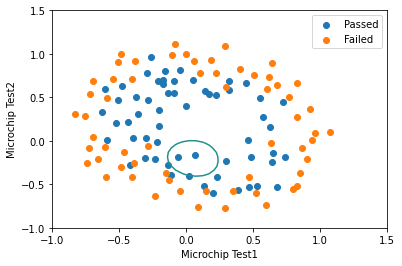

In [39]:
# making decision boundary

u = np.linspace(-1, 1.5, 50)
v = np.linspace(-1, 1.5, 50)
z = np.zeros((len(u), len(v)))

def mapFeatureForPlotting(x1, x2):
    degree = 6
    out = np.ones(1)
    for i in range(1, degree+1):
        for j in range(i+1):
            out = np.hstack((out, np.multiply(np.power(x1, i-j), np.power(x2, j))))
    return out

for i in range(len(u)):
    for j in range(len(v)):
        z[i,j]=np.dot(mapFeatureForPlotting(u[i],v[j]),regressor.weights)

mask = y.flatten() == 1
x = df.iloc[:,:-1]
passed = plt.scatter(x[mask][0], x[mask][1])
failed = plt.scatter(x[~mask][0], x[~mask][1])
plt.contour(u,v,z,0)
plt.xlabel('Microchip Test1')
plt.ylabel('Microchip Test2')
plt.legend((passed, failed), ('Passed', 'Failed'))
plt.show()

In [69]:
for i in range(6):
    Z_train = mapFeature(X_train,degree = i+1)
    regressor.fit(Z_train,Y_train)
    Z_test = mapFeature(X_test,degree = i+1)
    prediction = regressor.predict(Z_test)
    # print(f"Shape {regressor.weights.shape}")
    ## Reshape the weight matix
    regressor.weights = regressor.weights.reshape(-1,1)
    linear_model = np.dot(Z_test, regressor.weights) + regressor.bias
    h_w = sigmoid(regressor.weights.T,linear_model)
    print(f"The accuracy of the Logitic regression model is : {cross_entropy(Y_test, h_w)}")

The accuracy of the Logitic regression model is : 0.04620981203732957
The accuracy of the Logitic regression model is : 0.04620981203734797
The accuracy of the Logitic regression model is : 0.04620981203734975
The accuracy of the Logitic regression model is : 0.04620981203736094
The accuracy of the Logitic regression model is : 0.04620981203736149
The accuracy of the Logitic regression model is : 0.046209812037365135


In [60]:
regressor.weights[1:].shape

(5, 1)

In [72]:
for i in range(6):
    print(f"\n--------------------------------------------\nFor Q = {i+1}")
    Z_train = mapFeature(X_train,degree = i+1)
    regressor.fit(Z_train,Y_train)
    Z_test = mapFeature(X_test,degree = i+1)
    prediction = regressor.predict(Z_test)
    print(f"Training Loss : {regressor.loss}")
    ## Reshape the weight matix
    regressor.weights = regressor.weights.reshape(-1,1)
    linear_model = np.dot(Z_test, regressor.weights) + regressor.bias
    y_pred = sigmoid(regressor.weights.T,linear_model)
    Y_test = Y_test.reshape(-1,1)
    print(f"Testing Loss : {cross_entropy(Y_test,y_pred)}")


--------------------------------------------
For Q = 1
Training Loss : 2.33393046303573e-09
Testing Loss : 0.04620981203732957

--------------------------------------------
For Q = 2
Training Loss : 1.1047292143699523e-07
Testing Loss : 0.04620981203734797

--------------------------------------------
For Q = 3
Training Loss : 1.3548503893537597e-07
Testing Loss : 0.04620981203734975

--------------------------------------------
For Q = 4
Training Loss : 1.934070792913351e-07
Testing Loss : 0.04620981203736094

--------------------------------------------
For Q = 5
Training Loss : 2.1861317216588139e-07
Testing Loss : 0.04620981203736149

--------------------------------------------
For Q = 6
Training Loss : 2.5540259769711454e-07
Testing Loss : 0.046209812037365135
